In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score

### Import and Prep Data

In [7]:
# df = pd.read_csv(f"datafiles/hashed_ids.csv")

# # explode() doesn't work without these manipulations, though it really should
# df['games_played'] = df['games_played'].str.replace("'","")
# df['games_played'] = df['games_played'].str.replace("[","")
# df['games_played'] = df['games_played'].str.replace("]","")
# df['games_played'] = df['games_played'].str.split(",")

# df = df.explode('games_played')
# df.columns = ['user', 'game']
# df['game'] = df['game'].str.strip()
# df.to_csv("input.csv", index = False)

df = pd.read_csv("datafiles/input.csv")

In [11]:
# what are the top games?
gamecount = pd.DataFrame(df.groupby('game')['user'].count())
gamecount = gamecount.reset_index()
gamecount.columns = ['game', 'num_players']
gamecount = gamecount.sort_values('num_players', ascending = False)

fig, ax = plt.subplots(figsize = (12,6))
ax.bar(gamecount['game'][:20],gamecount['num_players'][:20])
ax.set_title("Number of Players Per Game, Top 10 Games", size = 14)
plt.yticks(size = 11)
plt.xticks(rotation = 90, size = 13)
plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.7)# plt.figure(num = 'top games', figsize = (24,6))

# plt.tight_layout()
plt.savefig("datafiles/top_games.png", bbox_inches = "tight") # bbox_inches stops the long xlabel getting cropped out
plt.show()

### convert to form we can cluster

In [12]:
# now the games will be the columns, and a 1 will indicate the user played that game
matrix = df.pivot(index = 'user', columns = 'game', values = 'user') # this is returning the user id as the value in the cell
matrix = matrix / matrix # feels hacky - converts cell values to 1, by dividing the user id by itself. is this terrible or amazing?
matrix.head()

game             NaN  Counter-Strike  Counter-Strike: Condition Zero  \
user                                                                   
259925500248     NaN             NaN                             NaN   
26691807445163   NaN             NaN                             NaN   
50693556088479   NaN             NaN                             NaN   
82030213274530   NaN             NaN                             NaN   
117100159133367  NaN             NaN                             NaN   

game             Counter-Strike: Condition Zero Deleted Scenes  \
user                                                             
259925500248                                               NaN   
26691807445163                                             NaN   
50693556088479                                             NaN   
82030213274530                                             NaN   
117100159133367                                            NaN   

game             Counter-Strike: Global Offensive  Counter-Strike: Source  \
user                                                                        
259925500248                                  1.0                     NaN   
26691807445163                                1.0                     1.0   
50693556088479                                1.0                     NaN   
82030213274530                                1.0                     NaN   
117100159133367                               1.0                     NaN   

game             Day of Defeat  Day of Defeat: Source  Deathmatch Classic  \
user                                                                        
259925500248               NaN                    NaN                 NaN   
26691807445163             NaN                    1.0                 NaN   
50693556088479             NaN                    NaN                 NaN   
82030213274530             NaN                    NaN                 NaN   
117100159133367            NaN                    NaN                 NaN   

game             Half-Life  ...  Half-Life Deathmatch: Source  \
user                        ...                                 
259925500248           NaN  ...                           NaN   
26691807445163         NaN  ...                           NaN   
50693556088479         NaN  ...                           1.0   
82030213274530         NaN  ...                           NaN   
117100159133367        NaN  ...                           NaN   

game             Half-Life: Blue Shift  Half-Life: Opposing Force  \
user                                                                
259925500248                       NaN                        NaN   
26691807445163                     NaN                        NaN   
50693556088479                     NaN                        NaN   
82030213274530                     NaN                        NaN   
117100159133367                    NaN                        NaN   

game             Half-Life: Source  Left 4 Dead  Left 4 Dead 2  Portal  \
user                                                                     
259925500248                   NaN          NaN            1.0     NaN   
26691807445163                 NaN          NaN            1.0     NaN   
50693556088479                 NaN          NaN            1.0     1.0   
82030213274530                 NaN          NaN            NaN     NaN   
117100159133367                NaN          NaN            NaN     NaN   

game             Portal 2  Ricochet  Team Fortress Classic  
user                                                        
259925500248          1.0       NaN                    NaN  
26691807445163        NaN       NaN                    NaN  
50693556088479        1.0       NaN                    NaN  
82030213274530        NaN       NaN                    NaN  
117100159133367       NaN       NaN                    NaN  

[5 rows x 25 columns]

In [13]:
# matrix.to_sparse() raises a deprecation error. This appears to be the preferred methodology
matrix = matrix.fillna(0)
matrix = matrix.astype(pd.SparseDtype(int, fill_value=0))
sparsity = str(round(matrix.sparse.density * 100, 2)) 
print(sparsity+"% of the dataframe is not sparse, so using a sparse matrix is better for memory consumption")

27.86% of the dataframe is not sparse, so using a sparse matrix is better for memory consumption


### find optimal number of clusters

In [15]:
scores = []

matrix = matrix[:200_000]

for num_clusters in range(3,21,1):
    
    # define model
    clf = KModes(n_clusters = num_clusters,
                 init = 'Huang', # I believe Cao has a consideration of density, which I'll avoid for the first attempt
                 n_init = 1,
                 n_jobs = -2, # all cpu cores except 1
                 random_state = 42)
    
    # evaluate
    preds = clf.fit_predict(matrix)
    sil_score = silhouette_score(matrix, preds)
    scores.append((num_clusters, sil_score)) # append tuple of number of clusters and resulting score, so we can make elbow plot
    
    print(f"sillhouette score is {round(sil_score,4)} with {num_clusters} clusters")

sillhouette score is 0.4128 with 3 clusters
sillhouette score is 0.458 with 4 clusters
sillhouette score is 0.4669 with 5 clusters
sillhouette score is 0.4666 with 6 clusters
sillhouette score is 0.465 with 7 clusters
sillhouette score is 0.4635 with 8 clusters
sillhouette score is 0.4297 with 9 clusters
sillhouette score is 0.4305 with 10 clusters
sillhouette score is 0.441 with 11 clusters
sillhouette score is 0.4461 with 12 clusters
sillhouette score is 0.4466 with 13 clusters
sillhouette score is 0.4546 with 14 clusters
sillhouette score is 0.4466 with 15 clusters
sillhouette score is 0.4365 with 16 clusters
sillhouette score is 0.4356 with 17 clusters
sillhouette score is 0.436 with 18 clusters
sillhouette score is 0.4269 with 19 clusters
sillhouette score is 0.4241 with 20 clusters


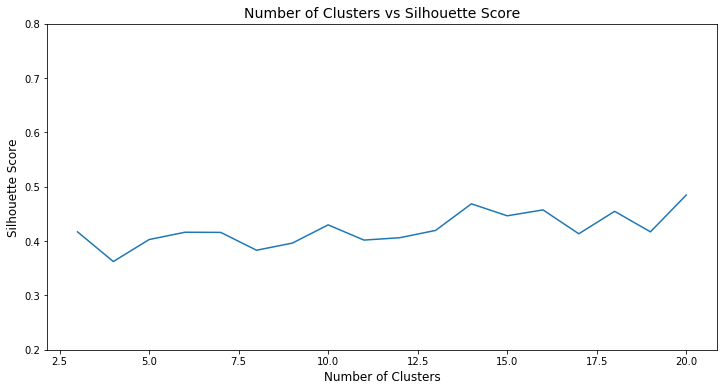

In [10]:
clusters = [i[0] for i in scores]
cluster_scores = [i[1] for i in scores]

fig, ax = plt.subplots(figsize = (12, 6))
ax.set_title("Number of Clusters vs Silhouette Score", size = 14)
ax.plot(clusters, cluster_scores,)
ax.set_xlabel("Number of Clusters", size = 12)
ax.set_ylabel("Silhouette Score", size = 12)
ax.set_ylim(0.2, 0.8)

plt.savefig('datafiles/silhouette_vis.png')
plt.show()

In [14]:
# lets go with 10 clusters - it's the highest performer for a while, and 14 really feels like too much.
clf = KModes(n_clusters = 10,
                 init = 'Huang', # I believe Cao has a consideration of density, which I'll avoid for the first attempt
                 n_init = 1,
                 n_jobs = -2, # all cpu cores except 1
                 random_state = 42)
    
# evaluate
preds = clf.fit_predict(matrix)

with open('datafiles/kmodes.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [63]:
# ok let's profile each cluster - what games do they like?
clusters_favourite_games = {}

matrix['cluster'] = preds
for cluster in matrix['cluster'].unique():
    subset = matrix[matrix['cluster'] == cluster].copy()
    purchases = subset.drop([np.nan, 'cluster'], axis = 1).sum()
    top_games = purchases.sort_values(ascending = False)[:10].index
    clusters_favourite_games[cluster] = list(top_games)

with open('datafiles/clusters_top_games.pkl', 'wb') as file:
    pickle.dump(clusters_favourite_games, file)

In [132]:
# and lets make some recommendations!
with open('datafiles/kmodes.pkl', 'rb') as file:
    clf = pickle.load(file)

with open('datafiles/clusters_top_games.pkl', 'rb') as file:
    clusters_favourite_games = pickle.load(file)
    
# pick a random user from the dataset
random_user = matrix.iloc[np.random.randint(0, len(matrix))]
users_games = random_user[random_user > 0] # what have they played?
users_cluster = users_games['cluster'] # what's their cluster?
users_games = [i for i in users_games.index if i != 'cluster']

# what are the top games for their cluster?
popular_games = clusters_favourite_games[int(users_cluster)]
popular_games = [game for game in popular_games if game not in users_games]

if len(popular_games) > 0:
    print("user has played \n"+"\n".join([game+"," for game in users_games])[:-1]+".\n\nWe would recommend they play: \n"+"\n"
          .join(game+"," for game in popular_games)[:-1])
else:
    print("user has played all of the top 10 games for their cluster!")

user has played 
Counter-Strike,
Counter-Strike: Condition Zero,
Counter-Strike: Condition Zero Deleted Scenes,
Counter-Strike: Global Offensive,
Day of Defeat,
Deathmatch Classic,
Half-Life,
Half-Life 2,
Half-Life 2: Deathmatch,
Half-Life 2: Episode One,
Half-Life 2: Episode Two,
Half-Life 2: Lost Coast,
Half-Life Deathmatch: Source,
Left 4 Dead 2,
Portal,
Portal 2,
Ricochet.

We would recommend they play: 
Half-Life: Opposing Force
